# Loop: detecting excessive income

Business rationale for this project:

Detecting excessive income falls under fraud prevention. This makes the Aire API more robust as it will prevent the client granting loans to individuals who may not have been eligible/able to service given their actual annual income. As a bank, this helps to decrease the amount of (potentially) bad loans and thus has a positive impact on business profitability.

In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import raw data

train = pd.read_csv('C:\\Users\\Sonja\\loop_service-master\\data\\baseline\\baseline.csv',low_memory=False)
val = pd.read_csv('C:\\Users\\Sonja\\loop_service-master\\data\stream\\stream.csv',low_memory=False)

In [3]:
# combine dataframes - the below exercise will work best on a large as possible dataset
# no validation dataset is required for the purposes of this project

cols = val.columns # there are less columns in the validation dataset
train = train[cols]

data_comb = pd.concat([train, val])

In [4]:
# create column 'outliers' and assign 0 for now

data_comb['outliers'] = 0

# Data cleaning and creation of data subset

In [5]:
# the feature employment titles is very 'messy' - there are a myriad of similar yet slightly different titles;
# this analysis requires this feature to be cleaned up and job titles to be aggregated

# put all employment titles in lower case and replace nan 

data_comb['emp_title'] = data_comb['emp_title'].str.lower().replace(np.nan, 'none_provided', regex=True)

# aggregate employment titles - below are a few examples. To capture all job titles and thus the entire 
# dataset, this needs much more work.

def agg_titles(empl_title):
    if empl_title == 'rn':
        return 'registered nurse'
    elif empl_title == 'general manager':
        return 'manager'
    elif empl_title == 'office manager':
        return 'manager'
    else:
        return empl_title

data_comb['emp_title'] = data_comb['emp_title'].apply(agg_titles)
      
# address states should also be aggregated by regions, for instance by East Coast, West Coast, etc.


In [6]:
# determine the frequency of top 20 employment titles
from nltk import FreqDist

fdist = FreqDist(data_comb['emp_title'])

fdist = fdist.most_common(20)
print(fdist)

#get the titles
titles = [(i[0]) for i in fdist]

[('none_provided', 81954), ('manager', 32432), ('teacher', 22195), ('registered nurse', 18437), ('owner', 13472), ('supervisor', 9315), ('driver', 8915), ('sales', 8548), ('project manager', 6287), ('truck driver', 4881), ('director', 4613), ('president', 4541), ('engineer', 4270), ('sales manager', 3755), ('operations manager', 3552), ('vice president', 3479), ('police officer', 3428), ('store manager', 3252), ('attorney', 3175), ('accountant', 3159)]


(-0.5, 399.5, 199.5, -0.5)

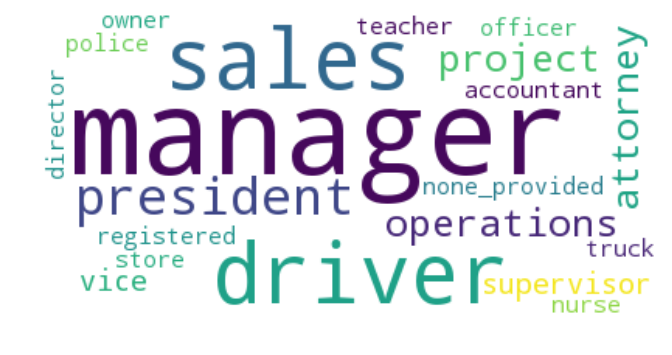

In [7]:
#What are the most frequent job titles?

from wordcloud import WordCloud, STOPWORDS

# adding specific stopwords
stopwords = set(STOPWORDS)
stopwords.add("Inc")
stopwords.add("null")

plt.figure(figsize=(8,6))
words = pd.DataFrame(titles).to_json()
wc = WordCloud(ranks_only=True,stopwords=stopwords, background_color='white',max_words=20).generate(words)             
plt.imshow(wc)
plt.axis("off")

In [8]:
# generate the reduced datasets only containing top 20 job titles
data_red = data_comb[data_comb['emp_title'].isin(titles)]

# now select the those features to be used
data_redux = data_red[['emp_title', 'addr_state', 'annual_inc', 'emp_length', 'verification_status']]
        
data_redux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243660 entries, 7 to 320815
Data columns (total 5 columns):
emp_title              243660 non-null object
addr_state             222589 non-null object
annual_inc             222667 non-null float64
emp_length             222572 non-null object
verification_status    222468 non-null object
dtypes: float64(1), object(4)
memory usage: 11.2+ MB


In [9]:
# deal with NAN values
# remove NAN values within annual income assuming that someone who left income blank would be flagged already 

data_redux = data_redux.dropna(subset=['annual_inc'])
data_redux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222667 entries, 7 to 320815
Data columns (total 5 columns):
emp_title              222667 non-null object
addr_state             221205 non-null object
annual_inc             222667 non-null float64
emp_length             221180 non-null object
verification_status    221072 non-null object
dtypes: float64(1), object(4)
memory usage: 10.2+ MB


# Outlier detection

**Detecting outliers (i.e. positive outliers for excessive income) using the Tukey method**

There are many "rules of thumb" for what constitutes an outlier in a dataset. I will use Tukey's Method for identfying outliers: An outlier step is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

The feature 'empl_title' is an important determinant of annual income. Currently, there are a myriad of different job titles. This feature would need much more work in order to aggregate or group job titles. 

For the purposes of this exercise, I will look at the 20 most common job titles provided by applicants and use that subset in the subsequent analysis, assuming that it is representative of the entire dataset.

I presume that income levels may vary from state to state, hence geography has to be considered when applying this method.

Thinking about the Loop service., it would be great to loop through all employment titles state by state and filter out all positive outliers. 
The output could then trigger a verification request for the annual income stated.

In order to detect outliers, I will assess annual income levels per employment title per state, like so:


In [10]:
# find the annual income with extreme high values (we can ignore the outliers to the downside)

def find_outliers(data):
    outliers_pts=pd.DataFrame(columns=data.columns)
    
    for title in data['emp_title'].unique():
        for state in data['addr_state'].unique():
    
            df = data[(data['emp_title']==title) & (data['addr_state']==state)]
            try:
                # calculate Q1 (25th percentile of the data)
                Q1 = np.percentile(df['annual_inc'], 25)

                # calculate Q3 (75th percentile of the data) 
                Q3 = np.percentile(df['annual_inc'], 75)

                # use the interquartile range to calculate the outlier step (1.5 times the interquartile range
                step = (Q3 - Q1) * 1.5

                # select the indices for data points
                outl= df[df['annual_inc'] >= Q3 + step]
                outliers_pts=outliers_pts.append(outl)
            except:
                sd=1
                
    return outliers_pts
    

In [11]:
# Display the outliers for training set

outliers = find_outliers(data_redux)
outliers['outliers'] = 1
print("Data points considered positive outliers for annual income by employment title by state:")
print("")
outliers

Data points considered positive outliers for annual income by employment title by state:



,emp_title,addr_state,annual_inc,emp_length,verification_status,outliers
100419,teacher,WA,122544.0,10+ years,Source Verified,1
119621,teacher,WA,134800.0,10+ years,Source Verified,1
163921,teacher,WA,121760.0,10+ years,Verified,1
399615,teacher,WA,120000.0,10+ years,Not Verified,1
408912,teacher,WA,120000.0,10+ years,Source Verified,1
569532,teacher,WA,138000.0,10+ years,Not Verified,1
10469,teacher,FL,99000.0,10+ years,Not Verified,1
37051,teacher,FL,120000.0,10+ years,Source Verified,1
101906,teacher,FL,88000.0,10+ years,Verified,1
105899,teacher,FL,110000.0,3 years,Source Verified,1


In [12]:
# update combined dataset

data_comb=data_comb.join(outliers['outliers'],rsuffix='_new')

In [13]:
data_comb['outliers_new']=data_comb['outliers_new'].fillna(0)

In [14]:
data_comb.drop('outliers', axis=1, inplace=True)

In [15]:
# how present are outliers in the combined dataset?

outlier_count = (data_comb.outliers_new == 1).sum()
count = len(data_comb.index)
not_outliers = count - outlier_count
perc_outliers_overall = round((float(outlier_count)/float(count))*100, 2)
perc_outliers_overall

1.57

In [16]:
# how present are unverified outliers in the combined dataset (referring to excessive income)? 

not_verified = data_comb[(data_comb['outliers_new']==1) & (data_comb['verification_status']=='Not Verified')]
outliers_not_verified = len(not_verified)

perc_outliers_not_verified = round((float(outliers_not_verified)/float(count))*100, 2)
print(perc_outliers_not_verified)
print(outliers_not_verified)

0.4
3878


# Conclusions

Using the Tukey method, I identified 1.57% of observations in the combined dataset as containing what could be regarded as unusually high income. 

The verified observations can be regarded as true and have to be filtered out, which leaves 0.4% of the overall dataset exhibiting unusually high income - a highly unbalanced dataset.

For the Loop service, this analysis could be run at stipulated intervals (e.g. end of each business day). Any applicants whose income was flagged as unusually high could be contacted to verify their income.

# Limitations

The Tukey method is simplistic and has a range of shortcomings:

a) It requires sufficient data to make quartile calculations representative. In this dataset, there is not  
   always sufficient data available for each employment title in each state. An aggregation of states by a few 
   regions such as East Coast, West Coast and Middle may help to address this issue.
   
b) Any skews in the annual income distribution per employment title per state are not captured. 

c) A lot of information is discarded (e.g. employment length), which could add value to this project.

# Recommendations

Predict annual income using more features:
    
    a) Try: K-Nearest Neighbors Regression.
    Features: Use employment title, employment length, address state;    
    Annual income is the target;
    Train/test split on the baseline dataset;
    Use stream as validation set;
    Look at predicted value vs. actual value, determine hurdle to flag 'excessive' e.g. % over actual income.
    
    b) Try: Light GBM Regression.
    Features: Take out those features with no predictive value or those with information leak vis-a-vis
    annual income. 
    Annual income is the target;
    Train/test split on the baseline dataset;
    Use stream as validation set;
    Tune parameters;
    Look at predicted value vs. actual value, determine hurdle to flag 'excessive' e.g. % over actual income.
    Look at feature importances to ascertain which features have the most predictive power.